In [9]:
import os
import uuid

import cv2
import numpy as np
from skimage.exposure import histogram
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
import pandas as pd
import pytesseract
import math


digits_classifier      = svm.LinearSVC(dual="auto")
hand_digits_classifier = svm.LinearSVC(dual="auto")
symbols_classifier     = svm.LinearSVC(dual="auto")
os.environ["TESSDATA_PREFIX"] = r'C:\Program Files\Tesseract-OCR\tessdata'
path_to_tesseract             = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = path_to_tesseract
svm_loaded = False

def find_vertical_lines(edges, thickness=8, forward=7, value=255, accumulate=False) -> []:
    lines = []
    x = 0
    # print(edges.shape)
    last_can_add = True
    while x < edges.shape[1]:
        ok = True
        disc = forward
        for y in range(edges.shape[0]):
            _connected = False
            for t in range(thickness):
                _x = x + t - thickness // 2
                if _x < 0 or _x >= edges.shape[1]:
                    continue
                _connected = _connected or edges[y, _x] == value

            if not _connected:
                disc -= 1
                if disc == 0:
                    ok = False
                    break
            else:
                if not accumulate:
                    disc = forward
        if ok:
            if not last_can_add:
                lines.append(x)
                last_can_add = True
        else:
            if last_can_add:
                lines.append(x - thickness // 2 if x > thickness // 2 - 1 else 0)
                last_can_add = False
        x += 1
    if len(lines) == 1:
        return []
    return lines


def find_horizontal_lines(edges, thickness=9, forward=7, value=255, accumulate=False) -> []:
    lines = []
    y = 0
    # print(edges.shape)
    last_can_add = True
    while y < edges.shape[0]:
        ok = True
        disc = forward
        for x in range(edges.shape[1]):
            _connected = False
            for t in range(thickness):
                _y = y + t - thickness // 2
                if _y < 0 or _y >= edges.shape[0]:
                    continue
                _connected = _connected or edges[_y, x] == value

            if not _connected:
                disc -= 1
                if disc == 0:
                    ok = False
                    break
            else:
                if not accumulate:
                    disc = forward
        if ok:
            if not last_can_add:  # this is the first line
                lines.append(y)
                last_can_add = True
        else:
            if last_can_add:
                lines.append(y - thickness // 2 if y > thickness // 2 - 1 else 0)
                last_can_add = False
        y += 1

    if len(lines) == 1:
        return []
    return lines

def apply_padding(items, Xfactor, Yfactor, Xtop=0.0, Ytop=0.0):
    out = []
    for k in items:
        w = k[2] - k[0]
        h = k[3] - k[1]
        xT = int(Xtop * w)
        yT = int(Ytop * h)
        xO = int(Xfactor * w)
        yO = int(Yfactor * h)
        out.append([k[0] + xO + xT, k[1] + yO + yT, k[2] - xO, k[3] - yO])
    return out

digit_padding = 4

def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated
    # titles. images[0] will be drawn with the title titles[0] if exists You aren't required to understand this
    # function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)

    plt.bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')
    plt.show()



def extract_hog_features(img , target_img_size=(32,32)):
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)

    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

def load_digits_dataset():
    features = []
    labels = []
    img_filenames = os.listdir('digits_dataset')
    i = 0
    for fn in img_filenames:
        path = os.path.join('digits_dataset', fn)
        for ffn in os.listdir(path):
            labels.append(fn)
            img_path = os.path.join(path, ffn)
            img = cv2.imread(img_path)
            features.append(extract_hog_features(img))
            # print(f"Loading : {img_path}")

            i += 1
            if i > 0 and i % 100 == 0:
                print("[INFO] processed {}".format(i))
    return features, labels

def load_symbols_dataset():
    features = []
    labels = []
    img_filenames = os.listdir('symbols_dataset')
    i = 0
    for fn in img_filenames:
        path = os.path.join('symbols_dataset', fn)
        for ffn in os.listdir(path):
            labels.append(fn)
            img_path = os.path.join(path, ffn)
            img = cv2.imread(img_path)
            features.append(extract_hog_features(img , target_img_size=(100,40)))
            # print(f"Loading : {img_path}")
            i += 1
            if i > 0 and i % 100 == 0:
                print("[INFO] processed {}".format(i))
    return features, labels

def load_hand_digits_dataset():
    features = []
    labels = []
    img_filenames = os.listdir('hand_digits_dataset')
    i = 0
    for fn in img_filenames:
        path = os.path.join('hand_digits_dataset', fn)
        for ffn in os.listdir(path):
            labels.append(fn)
            img_path = os.path.join(path, ffn)
            img = cv2.imread(img_path)
            features.append(extract_hog_features(img))
            # print(f"Loading : {img_path}")
            i += 1
            if i > 0 and i % 100 == 0:
                print("[INFO] processed {}".format(i))
    return features, labels


def load_svm():
    features, labels = load_digits_dataset()
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2)
    digits_classifier.fit(train_features, train_labels)
    accuracy = digits_classifier.score(test_features, test_labels)
    print(f"accuracy: {accuracy * 100} %")
    
    features, labels = load_symbols_dataset()
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2)
    symbols_classifier.fit(train_features, train_labels)
    accuracy = symbols_classifier.score(test_features, test_labels)
    print(f"accuracy: {accuracy * 100} %")
    
    features, labels = load_hand_digits_dataset()
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2)
    hand_digits_classifier.fit(train_features, train_labels)
    accuracy = hand_digits_classifier.score(test_features, test_labels)
    print(f"accuracy: {accuracy * 100} %")
    
    global svm_loaded
    svm_loaded = True
    
load_svm()
    

[INFO] processed 100
accuracy: 100.0 %
[INFO] processed 100
[INFO] processed 200
[INFO] processed 300
accuracy: 100.0 %
[INFO] processed 100
[INFO] processed 200
[INFO] processed 300
[INFO] processed 400
[INFO] processed 500
[INFO] processed 600
[INFO] processed 700
[INFO] processed 800
[INFO] processed 900
[INFO] processed 1000
[INFO] processed 1100
[INFO] processed 1200
[INFO] processed 1300
[INFO] processed 1400
[INFO] processed 1500
[INFO] processed 1600
[INFO] processed 1700
[INFO] processed 1800
[INFO] processed 1900
[INFO] processed 2000
[INFO] processed 2100
[INFO] processed 2200
[INFO] processed 2300
[INFO] processed 2400
[INFO] processed 2500
[INFO] processed 2600
[INFO] processed 2700
[INFO] processed 2800
[INFO] processed 2900
[INFO] processed 3000
[INFO] processed 3100
[INFO] processed 3200
[INFO] processed 3300
[INFO] processed 3400
[INFO] processed 3500
[INFO] processed 3600
[INFO] processed 3700
[INFO] processed 3800
[INFO] processed 3900
[INFO] processed 4000
[INFO] pr

The INPUT_FILE is the path to the image you want to auto grade
set OCR_ENABLED to true if you want to use the OCR to detect numbers instead of the classifier
(in case of using OCR , you need to set the paths of "tesseract" executable in the about cell)

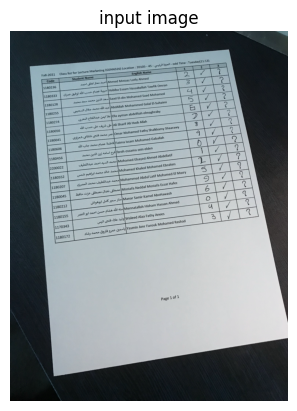

In [10]:
#select parameters here
INPUT_FILE = f'inputs/10.jpg'
OCR_ENABLED = False

img = cv2.imread(INPUT_FILE)
show_images([img] , ["input image"])


This applies some minor post-processing to the image (making the dark colors darker)

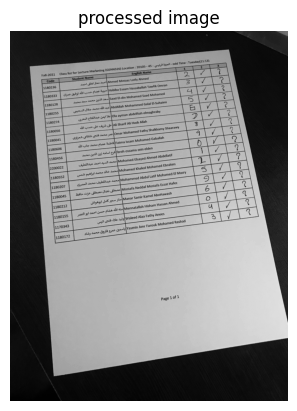

In [11]:
def gamma_correction(img, gamma=1.0):
    if gamma == 1:
        return img

    img = img.astype(np.float32) / 255
    img = np.power(img, gamma)
    return (img * 255).astype(np.uint8)

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_image = gamma_correction(gray_image , 1.3)
show_images([gray_image] , ["processed image"])

This part extracts the paper from the image

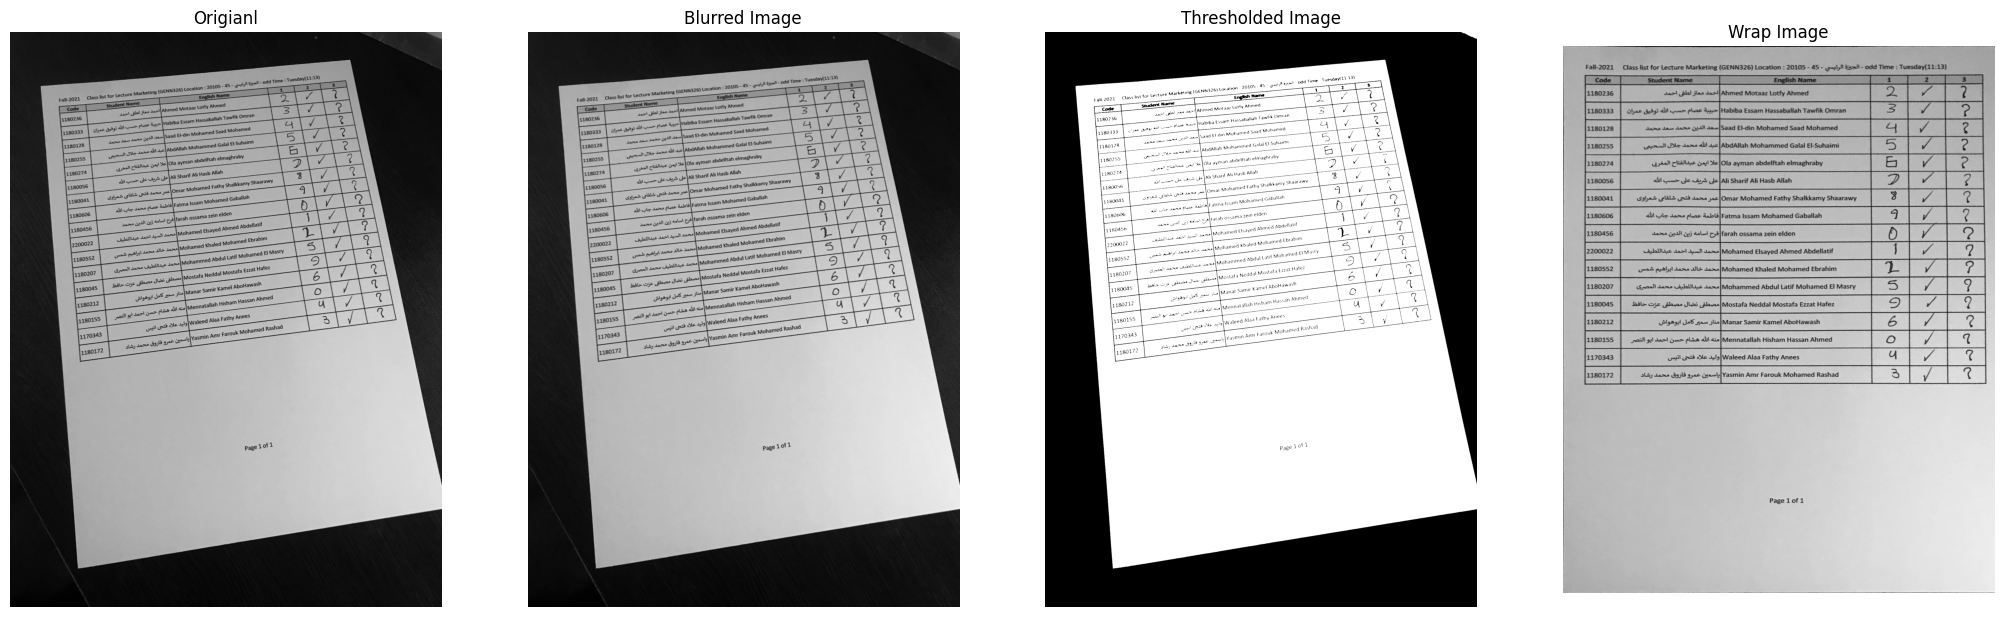

In [12]:
def getPaper(img) -> np.array:
    blurred_image = cv2.GaussianBlur(img, (5, 5), 0)  # remove noise
    _, edges = cv2.threshold(blurred_image, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    edges = cv2.dilate(edges, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = max(contours, key=cv2.contourArea)

    epsilon = 0.1 * cv2.arcLength(largest_contour, True)
    approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)
    hull = cv2.convexHull(approx_polygon)

    # cv2.drawContours(img, largest_contour, contourIdx=-1, thickness=15, color=(255))

    x, y, w, h = cv2.boundingRect(approx_polygon)
    src_points = np.float32(hull)

    if (len(src_points)) > 4:
        print("Can't detect the box")
        return None

    top_left = [0, 0]
    bot_left = [0, h]
    top_right = [w, 0]
    bot_right = [w, h]

    top_left_i = 0
    bot_left_i = 0
    top_right_i = 0
    bot_right_i = 0

    i = 0
    center = [0, 0]
    while i < len(src_points):
        center += src_points[i][0]
        i = i + 1

    center[0] = center[0] / 4
    center[1] = center[1] / 4
    i = 0
    while i < len(src_points):
        v = src_points[i][0] - center
        if v[0] < 0 and v[1] < 0:
            top_left_i = i
        if v[0] > 0 > v[1]:
            top_right_i = i
        if v[0] > 0 and v[1] > 0:
            bot_right_i = i
        if v[0] < 0 < v[1]:
            bot_left_i = i
        i = i + 1

    dst_points = np.float32([
        [0, h],
        [w, h],
        [w, 0],
        [0, 0],
    ])

    dst_points[bot_left_i] = bot_left
    dst_points[bot_right_i] = bot_right
    dst_points[top_left_i] = top_left
    dst_points[top_right_i] = top_right

    # print(src_points)
    # print(dst_points)

    # print(src_points.shape)
    # print(dst_points.shape)

    perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_image = cv2.warpPerspective(img, perspective_matrix, (w, h))
    show_images([img , blurred_image , edges ,  warped_image] , ["Origianl" , "Blurred Image" , "Thresholded Image" , "Wrap Image"])

    return warped_image

paper = getPaper(gray_image)
# show_images([paper] , ["paper"])

This part extracts the table from the image

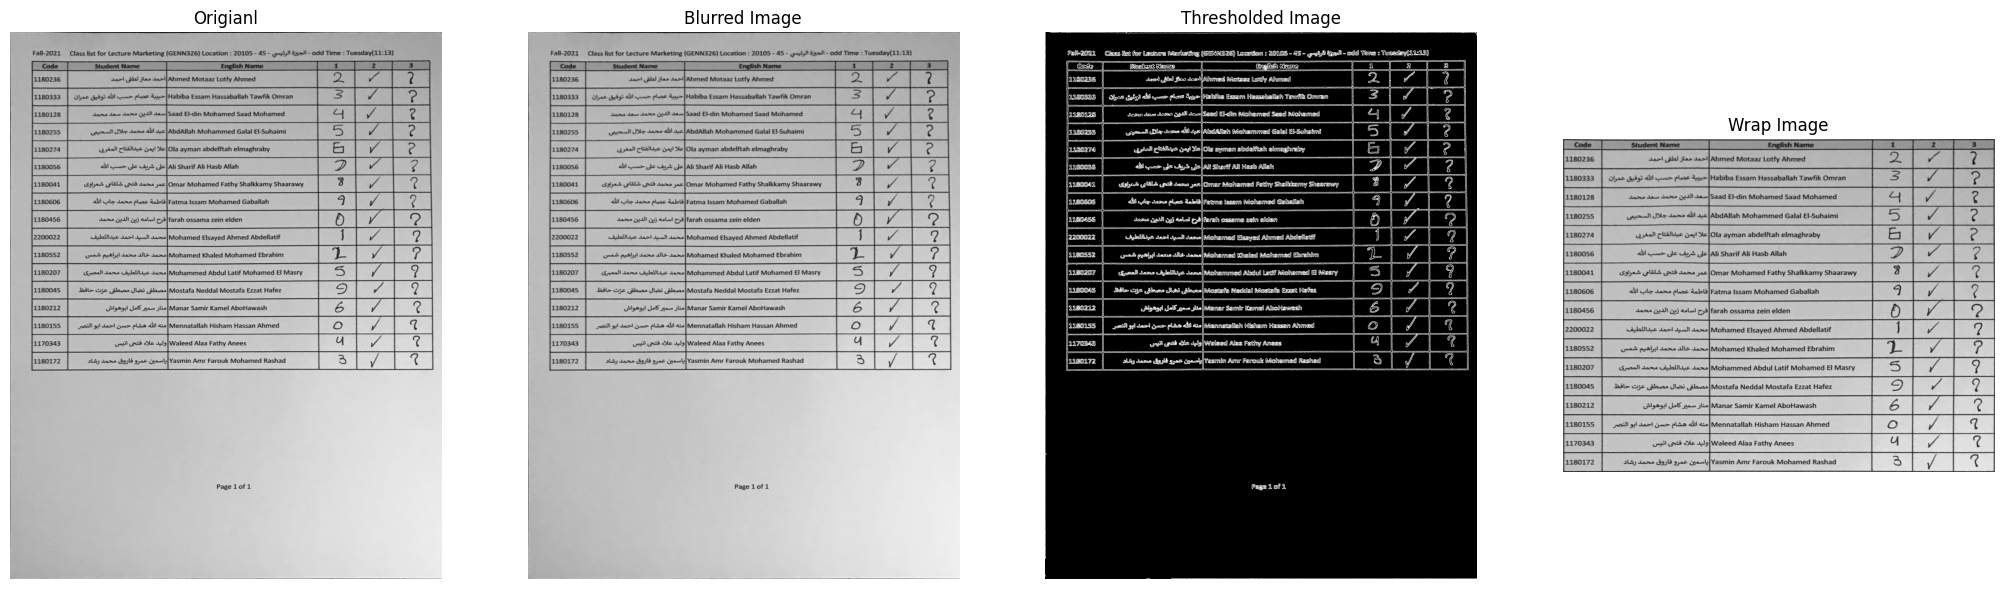

In [13]:
def getTable(img) -> np.array:
    blurred_image = cv2.GaussianBlur(img, (5, 5), 0)  # remove noise
    edges = cv2.Canny(blurred_image, 20, 120) # this is a really low threshold, but it works ..
    edges = cv2.dilate(edges, np.ones([3,3]))
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = max(contours, key=cv2.contourArea)

    epsilon = 0.04 * cv2.arcLength(largest_contour, True)
    approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)
    hull = cv2.convexHull(approx_polygon)

    # cv2.drawContours(img, largest_contour, contourIdx=-1, thickness=15, color=(255))
    # show_images([img , edges])

    x, y, w, h = cv2.boundingRect(hull)
    src_points = np.float32(hull)

    if (len(src_points)) > 4:
        print("Can't detect the box")
        return None

    top_left = [0, 0]
    bot_left = [0, h]
    top_right = [w, 0]
    bot_right = [w, h]

    top_left_i = 0
    bot_left_i = 0
    top_right_i = 0
    bot_right_i = 0

    i = 0
    center = [0, 0]
    while i < len(src_points):
        center += src_points[i][0]
        i = i + 1

    center[0] = center[0] / 4
    center[1] = center[1] / 4
    i = 0
    while i < len(src_points):
        v = src_points[i][0] - center
        if v[0] < 0 and v[1] < 0:
            top_left_i = i
        if v[0] > 0 > v[1]:
            top_right_i = i
        if v[0] > 0 and v[1] > 0:
            bot_right_i = i
        if v[0] < 0 < v[1]:
            bot_left_i = i
        i = i + 1

    dst_points = np.float32([
        [0, h],
        [w, h],
        [w, 0],
        [0, 0],
    ])

    dst_points[bot_left_i] = bot_left
    dst_points[bot_right_i] = bot_right
    dst_points[top_left_i] = top_left
    dst_points[top_right_i] = top_right

    # print(src_points)
    # print(dst_points)

    # print(src_points.shape)
    # print(dst_points.shape)

    perspective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_image = cv2.warpPerspective(img, perspective_matrix, (w, h))

    show_images([img , blurred_image , edges ,  warped_image] , ["Origianl" , "Blurred Image" , "Thresholded Image" , "Wrap Image"])

    return warped_image

table = getTable(paper)


This part process the table that has been extracted
extracting the cells and defines each cell type

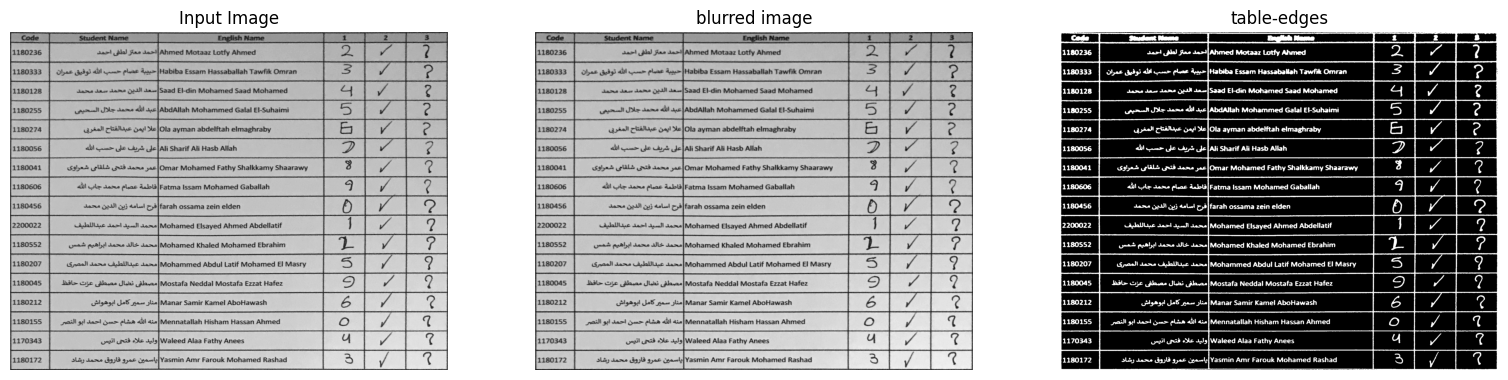

Extracted a total of : 17 rows , Qs: 3


In [14]:
def extract_table(table):
    # img = table.copy()
    blurred_image = cv2.GaussianBlur(table, (5, 5), 0)  # remove noise
    _, edges = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # edges = cv2.Canny(blurred_image, 50, 150)
    # edges = cv2.dilate(edges, np.ones([5, 5]))
    # show_images([edges])
    show_images([table, blurred_image, edges] , ["Input Image" , "blurred image" , "table-edges"])

    # TODO: performance heavy (I know there is a better way to do it but meh)
    ver = find_vertical_lines(edges,
                              forward=int(edges.shape[0] * 0.1),
                              thickness=int(edges.shape[1] * 0.01),
                              accumulate=True)
    hor = find_horizontal_lines(edges, forward=int(edges.shape[1] * 0.1),  accumulate=True)

    # print(ver[1] - ver[0])

    # cv2.imwrite("out.png", edges)

    # now calculate all the boxes we need
    i = 1
    codes = []  # x1 y1 x2 y1
    quests = []  #
    # codes_images = []
    # questions_images = []

    # print(table.shape)
    while i < len(hor) // 2:
        codes.append([ver[0], hor[i * 2], ver[1], hor[i * 2 + 1]])
        # codes_images.append(table[hor[i]: hor[i + 1], ver[0]: ver[1]])
        q = []
        # qi = []
        for k in range(3, len(ver) // 2):
            q.append([ver[k * 2], hor[i * 2], ver[k * 2 + 1], hor[i * 2 + 1]])
            # qi.append(table[hor[i]: hor[i + 1], ver[k]: ver[k + 1]])
        quests.append(q)
        # questions_images.append(qi)
        i = i + 1

    # debug stuff
    # i = 0
    # for img in codes_images:
    #     cv2.imwrite(f"code{i}.png", img)
    #     i = i + 1
    # show_images([edges, table, img])

    return codes, quests


codes_positions, questions_positions = extract_table(table)
codes_positions = apply_padding(codes_positions, Xfactor=0.05, Yfactor=0.05, Xtop=0.00, Ytop=0.0)

#print(codes_positions)
print(f"Extracted a total of : {len(codes_positions)} rows , Qs: {len(questions_positions[0])}")  # not safe
qp = []
for k in questions_positions:
    qp.append(apply_padding(k, Xfactor=0.05, Yfactor=0.05))
questions_positions = qp


This part of the code processes the data extracted form the table
including :
    - classification
    - result generating
    - result calculations

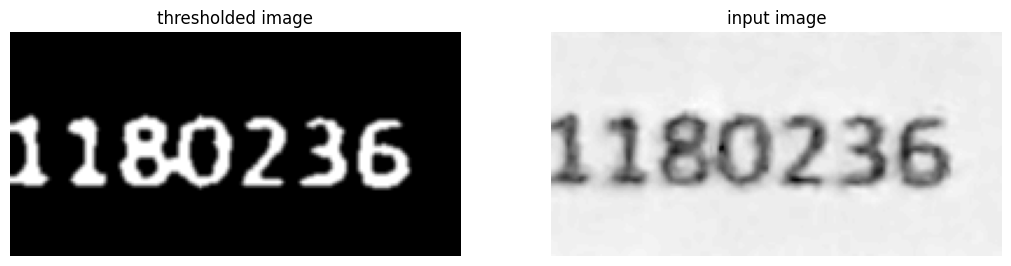

Attempting to split a wide digit image


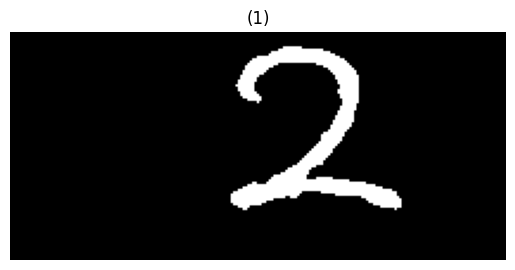

(66, 70)
Writing to : temp\46d50cb0-adac-4926-b259-55790e48c315.png


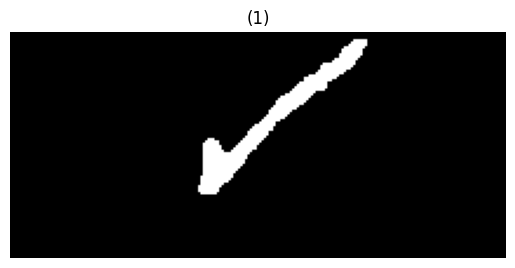

hor : 0 , ver: 0
Predict: correct


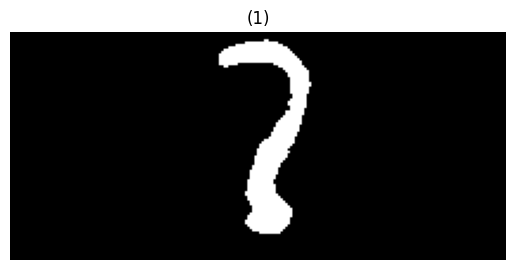

hor : 0 , ver: 0
Predict: question
['1180236', ['2', 5, '']]


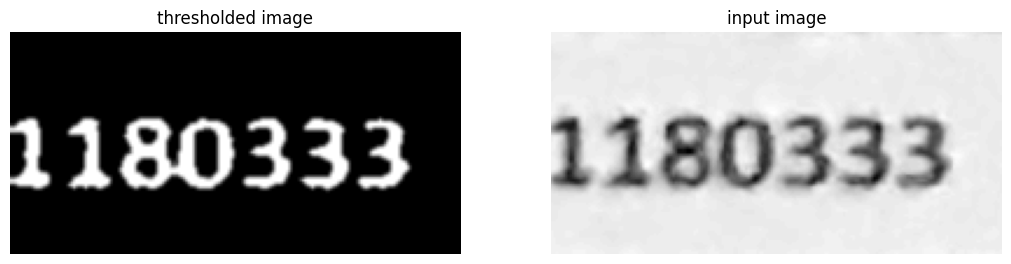

Attempting to split a wide digit image


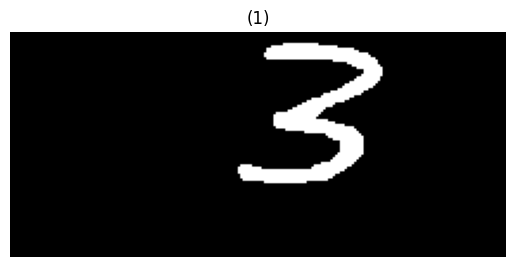

(57, 58)
Writing to : temp\d02cdd34-1454-464d-bbbf-23828dff2184.png


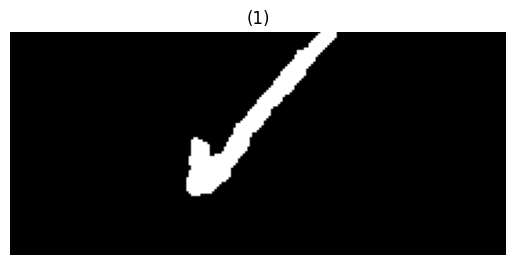

hor : 0 , ver: 0
Predict: correct


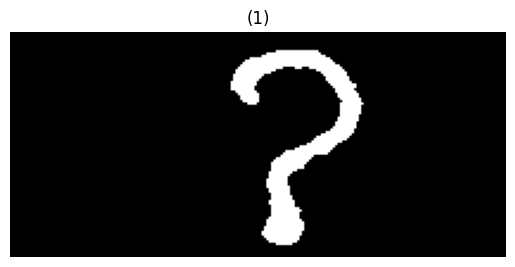

hor : 0 , ver: 0
Predict: question
['1180333', ['3', 5, '']]


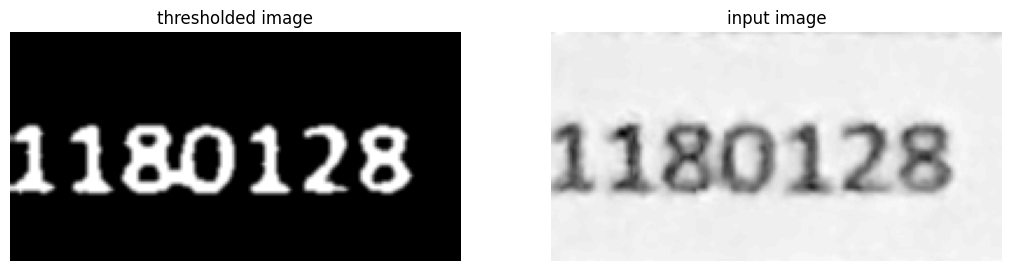

Attempting to split a wide digit image


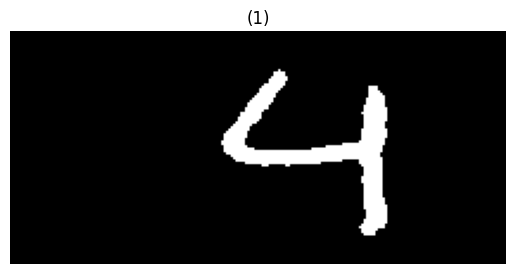

(67, 67)
Writing to : temp\026f7a77-58bd-431e-a8ee-6ea63b2c54ba.png


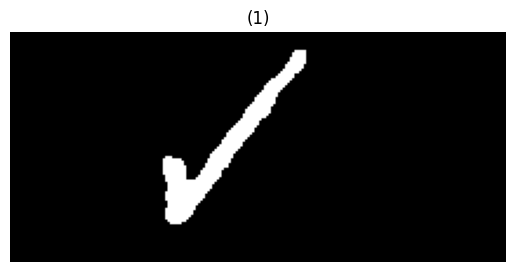

hor : 0 , ver: 0
Predict: correct


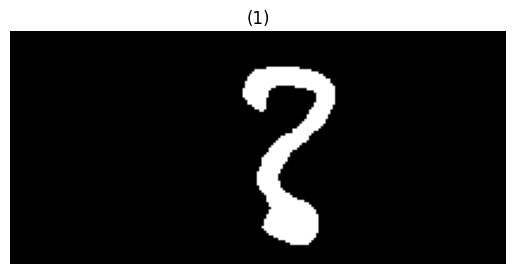

hor : 0 , ver: 0
Predict: question
['1180128', ['4', 5, '']]


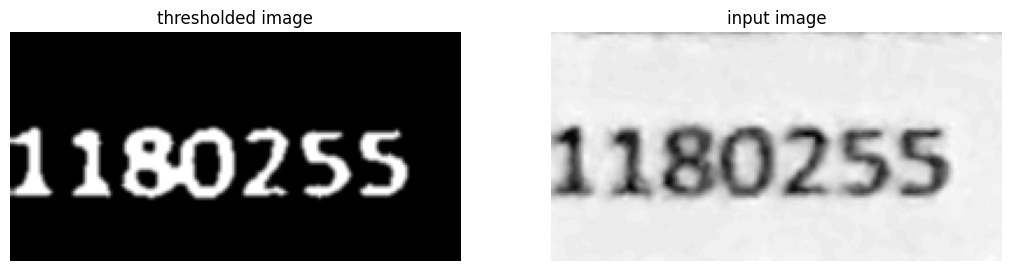

Attempting to split a wide digit image


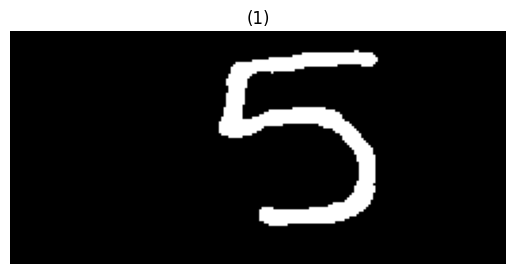

(71, 64)
Writing to : temp\b13f8875-a2f3-42b0-aaba-aa9513d4d23b.png


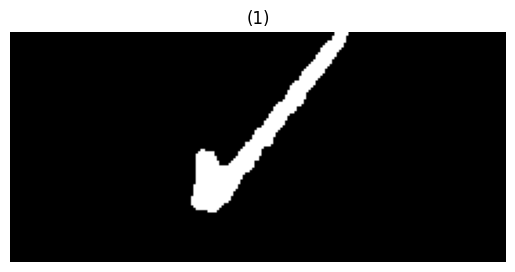

hor : 0 , ver: 0
Predict: correct


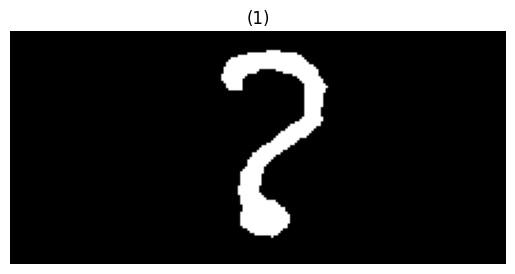

hor : 0 , ver: 0
Predict: question
['1180255', ['5', 5, '']]


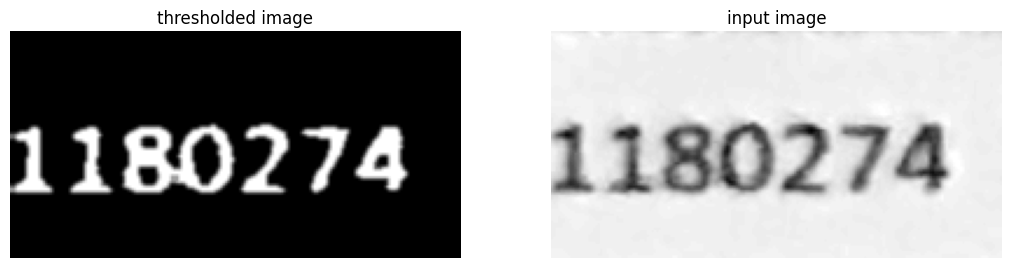

Attempting to split a wide digit image


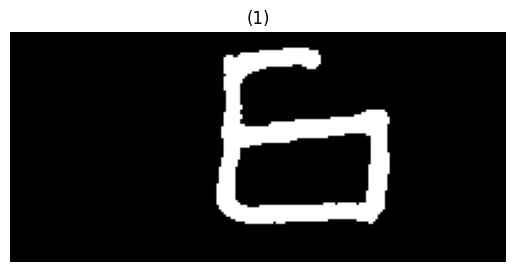

(72, 71)
Writing to : temp\94033d31-c968-400f-b3fe-36372aa3fa68.png


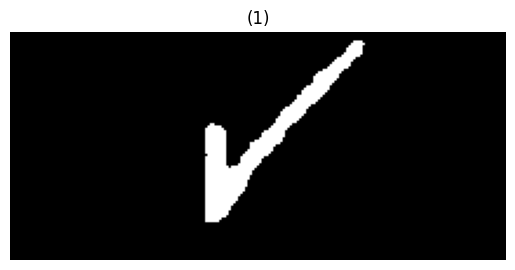

hor : 0 , ver: 0
Predict: correct


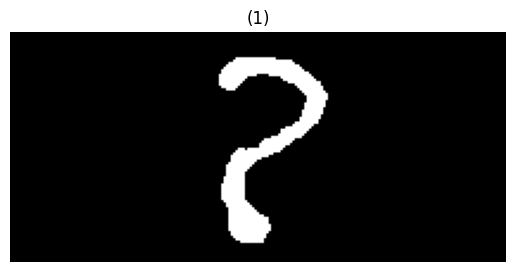

hor : 0 , ver: 0
Predict: question
['1180274', ['5', 5, '']]


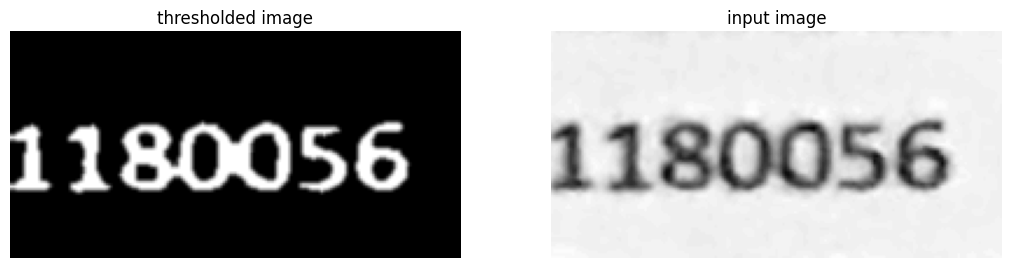

Attempting to split a wide digit image


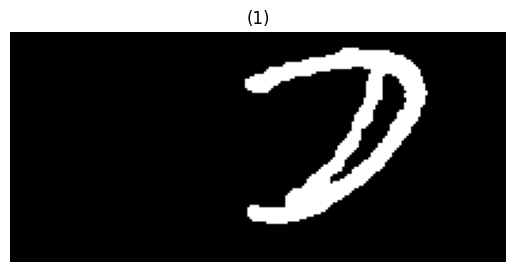

(72, 74)
Writing to : temp\17a02a5e-54c8-48f0-ad48-80e085b104af.png


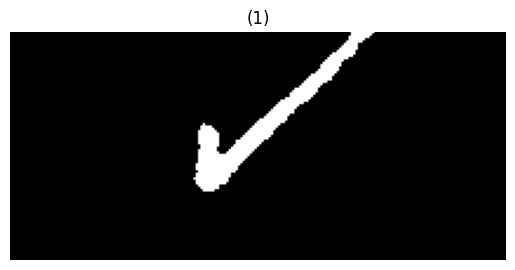

hor : 0 , ver: 0
Predict: correct


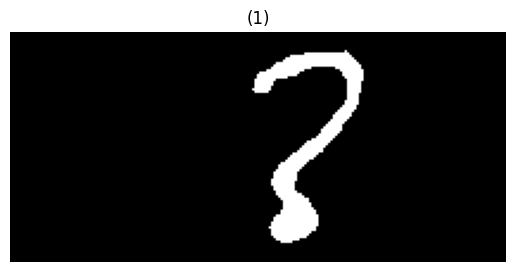

hor : 0 , ver: 0
Predict: question
['1180056', ['2', 5, '']]


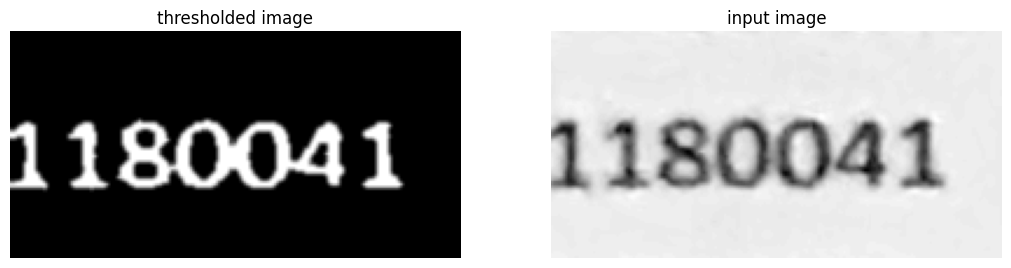

Attempting to split a wide digit image


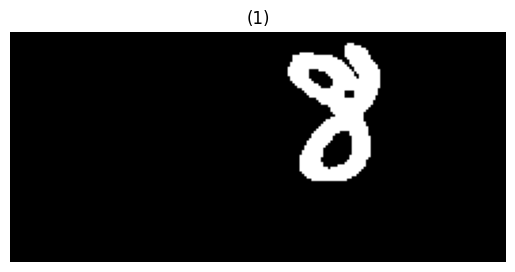

(55, 37)
Writing to : temp\84eca38a-9e0c-4627-802b-5b94641e3f4c.png


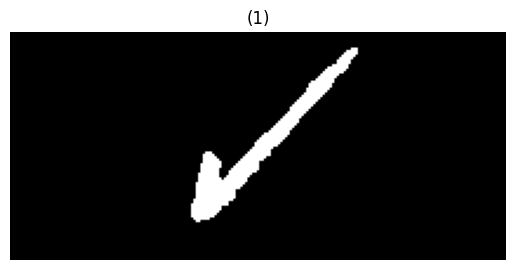

hor : 0 , ver: 0
Predict: correct


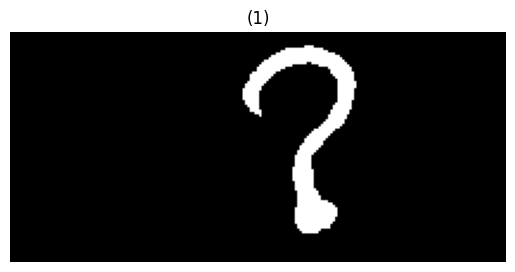

hor : 0 , ver: 0
Predict: question
['1180041', ['8', 5, '']]


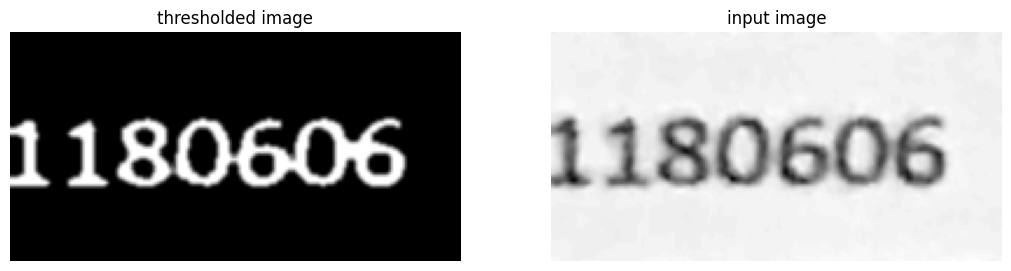

Attempting to split a wide digit image


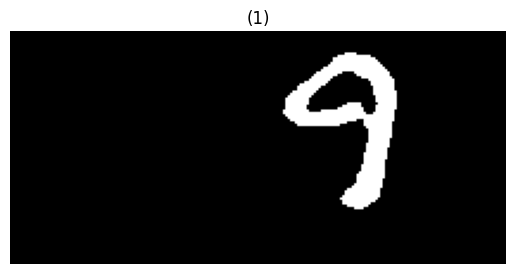

(64, 45)
Writing to : temp\d69d83d3-3b86-4904-839d-d9bb5a4a10bf.png


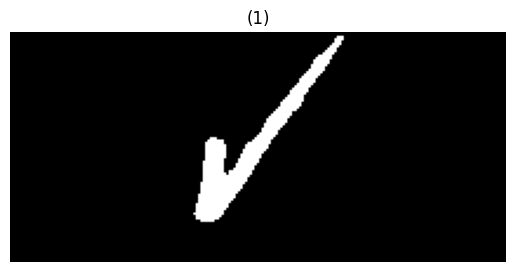

hor : 0 , ver: 0
Predict: correct


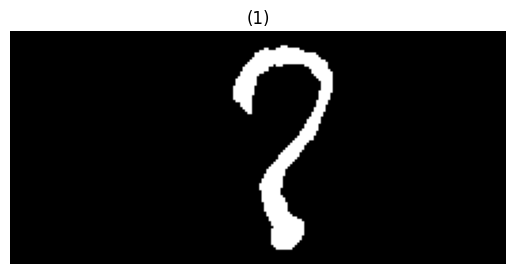

hor : 0 , ver: 0
Predict: question
['1180606', ['0', 5, '']]


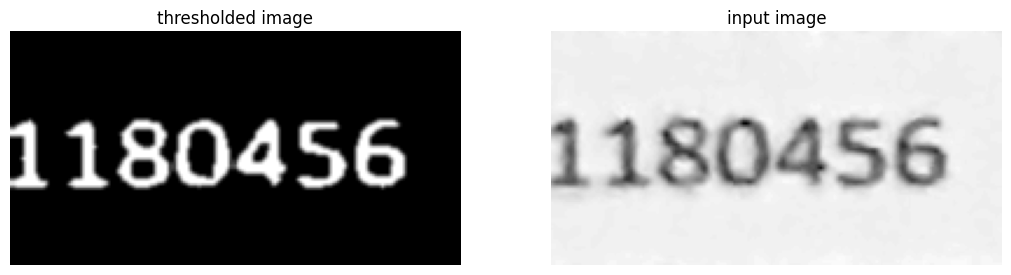

Attempting to split a wide digit image


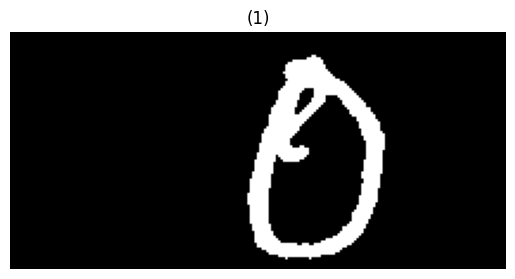

(82, 56)
Writing to : temp\7c7d98be-6ecf-41a3-ba12-d65fe0955b36.png


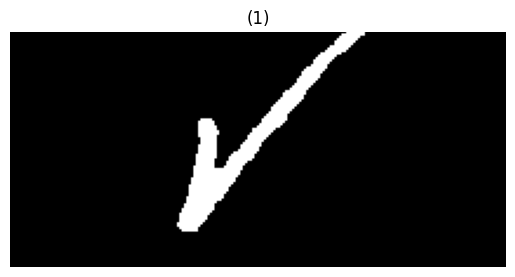

hor : 0 , ver: 0
Predict: correct


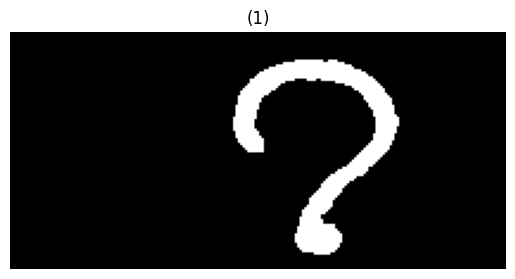

hor : 0 , ver: 0
Predict: question
['1180456', ['0', 5, '']]


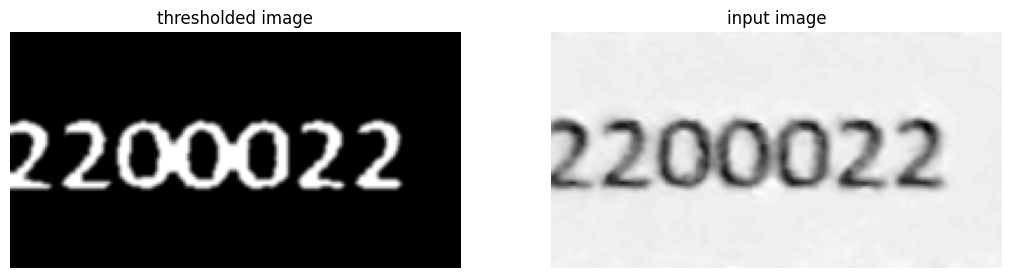

Attempting to split a wide digit image


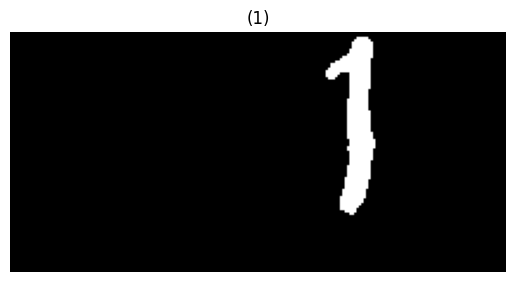

(72, 18)
Writing to : temp\b3b66c96-9068-4607-a0f8-39d1bdbc0109.png


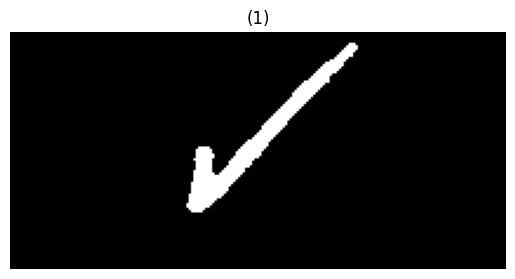

hor : 0 , ver: 0
Predict: correct


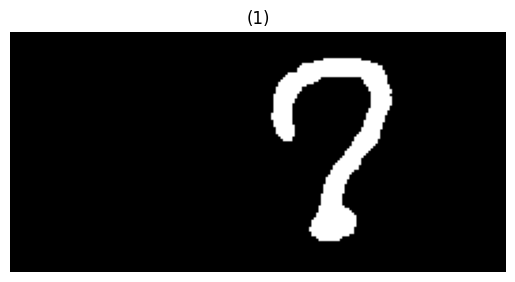

hor : 0 , ver: 0
Predict: question
['2200022', ['1', 5, '']]


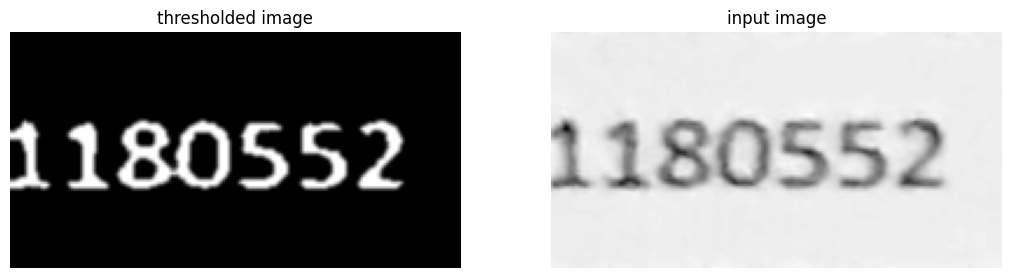

Attempting to split a wide digit image


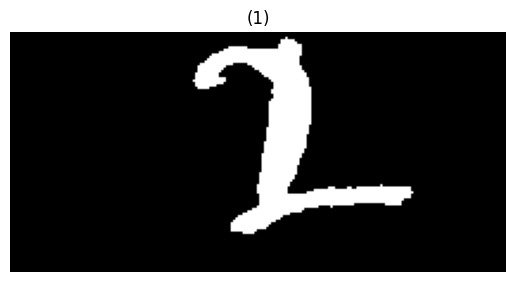

(80, 89)
Writing to : temp\178aa758-d9f3-496e-8e2b-62dd5eaef118.png


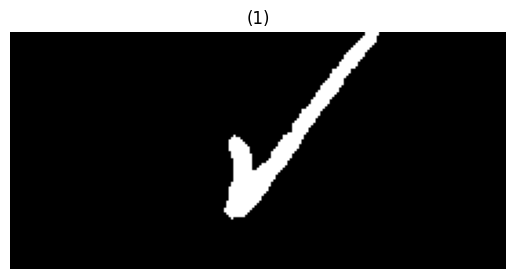

hor : 0 , ver: 0
Predict: correct


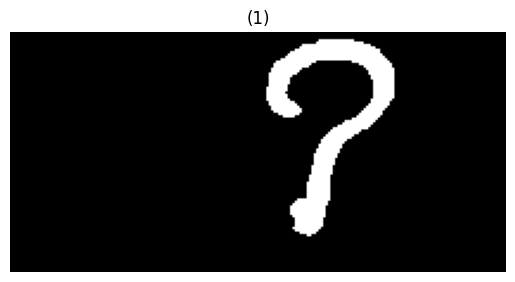

hor : 0 , ver: 0
Predict: question
['1180552', ['7', 5, '']]


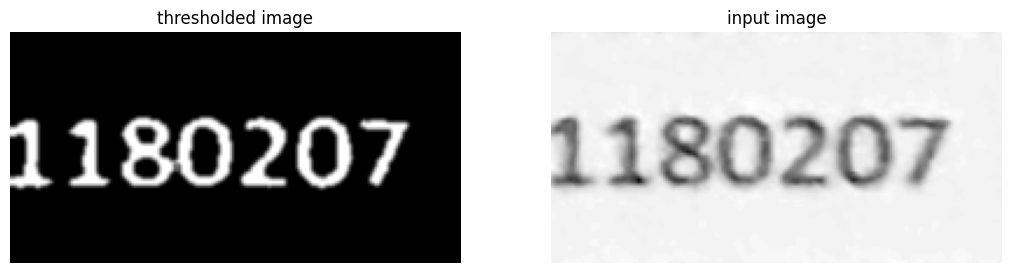

Attempting to split a wide digit image


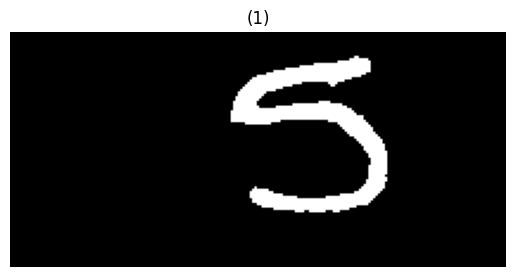

(63, 64)
Writing to : temp\55e44af7-d779-4b0a-8680-cd22617c0212.png


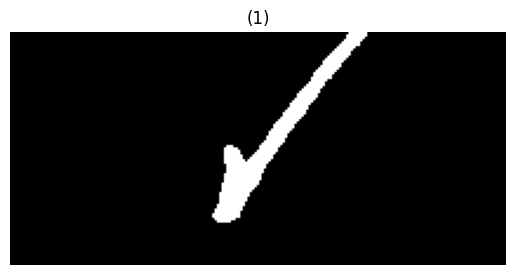

hor : 0 , ver: 0
Predict: correct


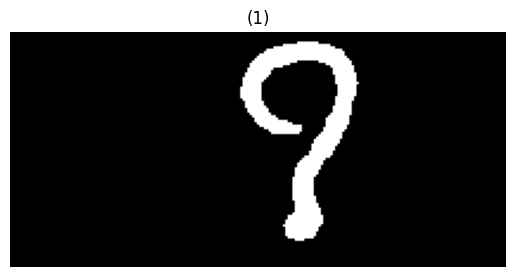

hor : 0 , ver: 0
Predict: question
['1180207', ['5', 5, '']]


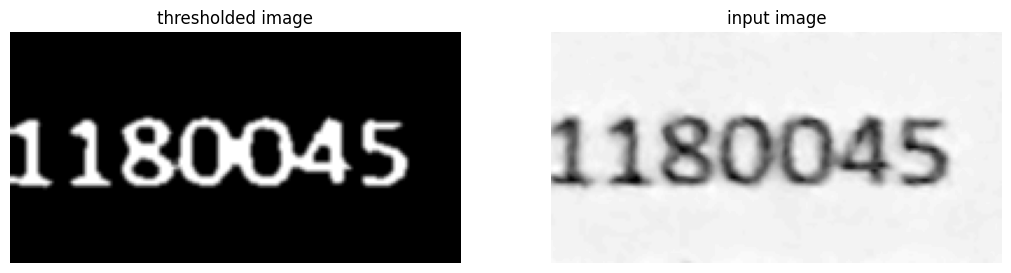

Attempting to split a wide digit image


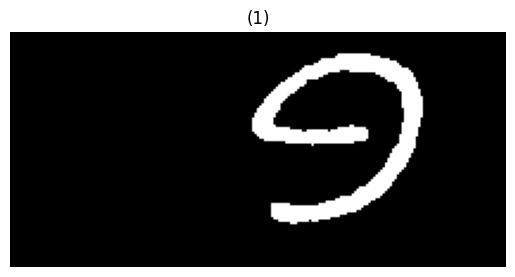

(69, 70)
Writing to : temp\6c8878db-17cf-4b08-8268-be04423102be.png


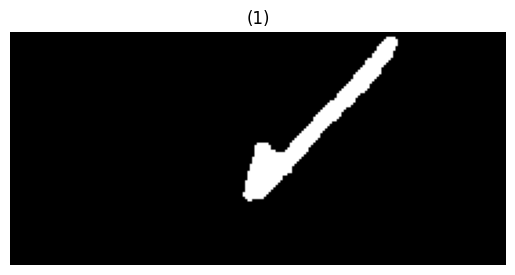

hor : 0 , ver: 0
Predict: correct


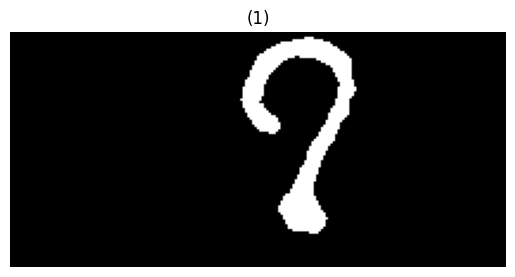

hor : 0 , ver: 0
Predict: question
['1180045', ['3', 5, '']]


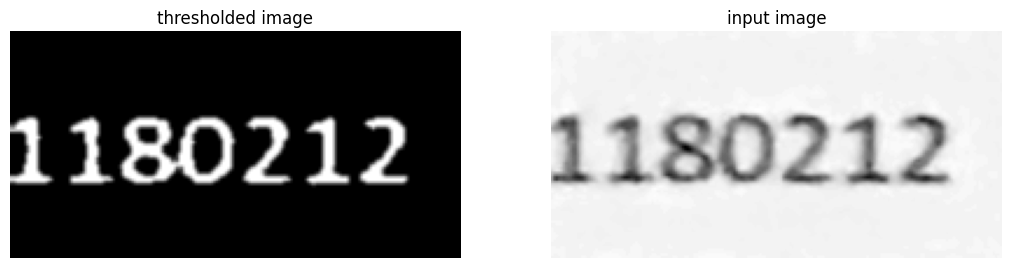

Attempting to split a wide digit image


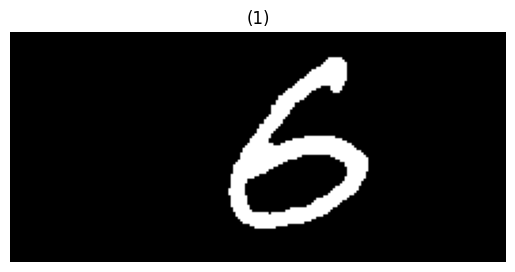

(70, 56)
Writing to : temp\3a0efc97-e0bd-49aa-81d5-a125a7182538.png


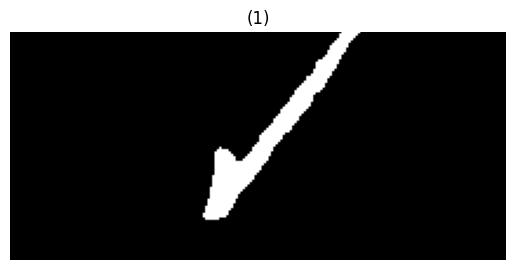

hor : 0 , ver: 0
Predict: correct


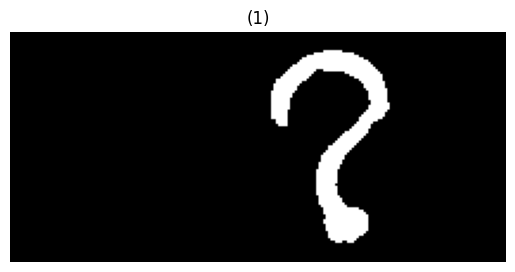

hor : 0 , ver: 0
Predict: question
['1180212', ['6', 5, '']]


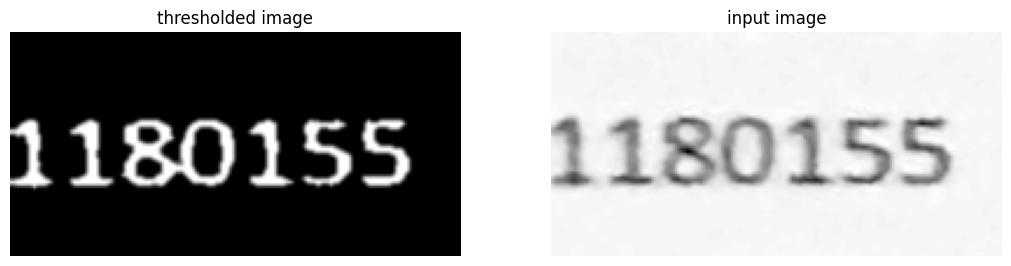

Attempting to split a wide digit image


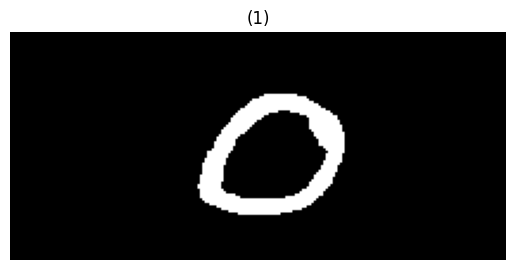

(49, 59)
Writing to : temp\ed92ecf8-e5bc-4af2-80d0-bf886f7b7bbf.png


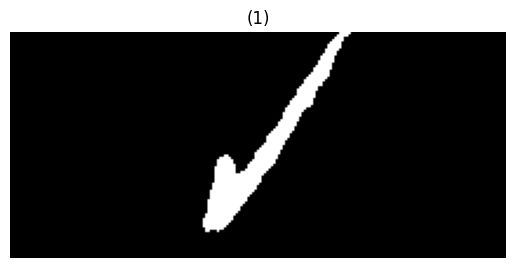

hor : 0 , ver: 0
Predict: correct


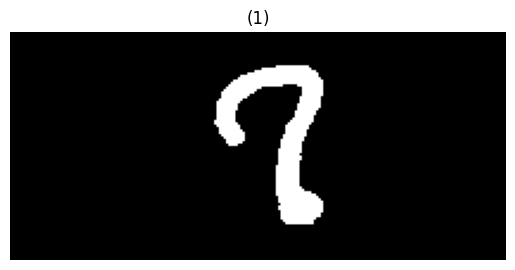

hor : 0 , ver: 0
Predict: question
['1180155', ['0', 5, '']]


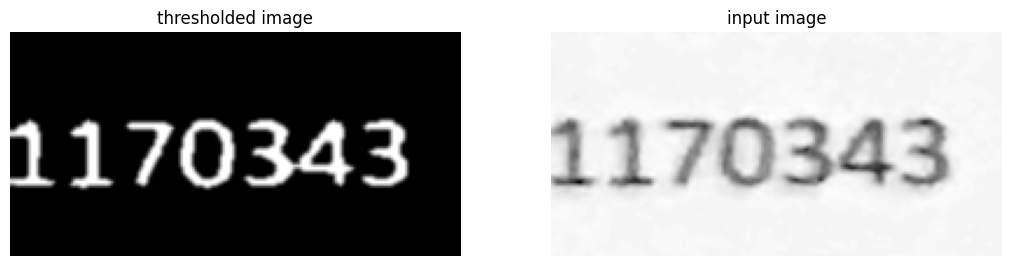

Attempting to split a wide digit image


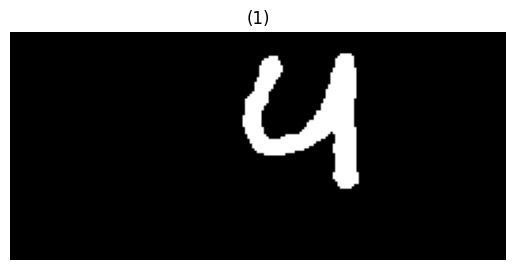

(55, 47)
Writing to : temp\c9f5f10d-2274-442f-8839-5b73dee50112.png


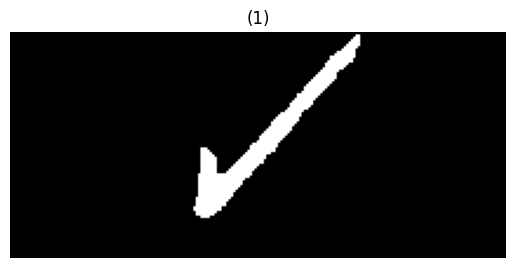

hor : 0 , ver: 0
Predict: correct


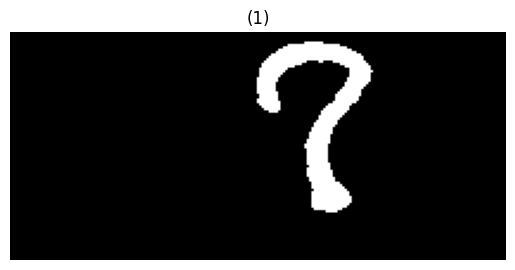

hor : 0 , ver: 0
Predict: question
['1170343', ['4', 5, '']]


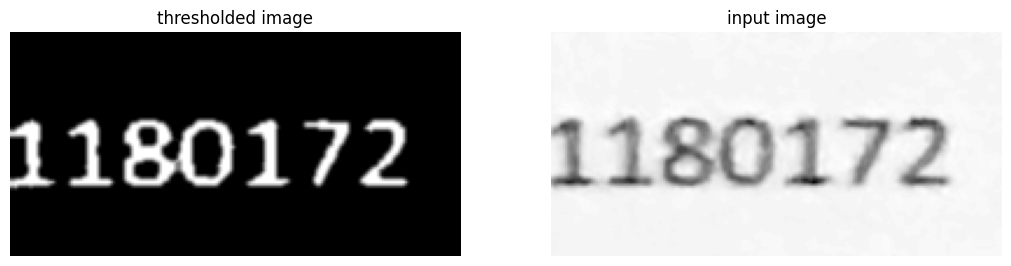

Attempting to split a wide digit image


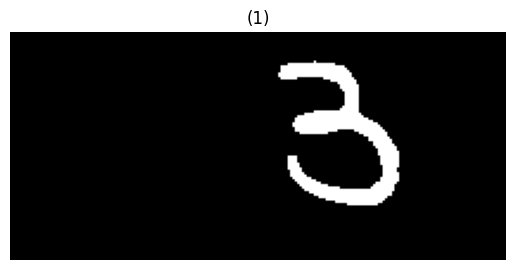

(58, 48)
Writing to : temp\f9ff8a60-2f5e-4f11-8dde-2b7778ab4041.png


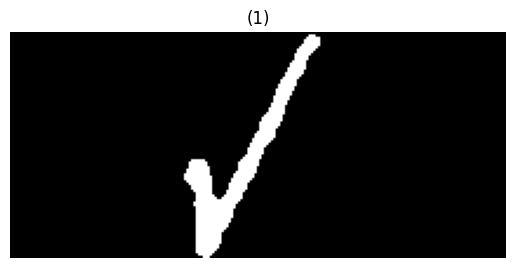

hor : 0 , ver: 0
Predict: correct


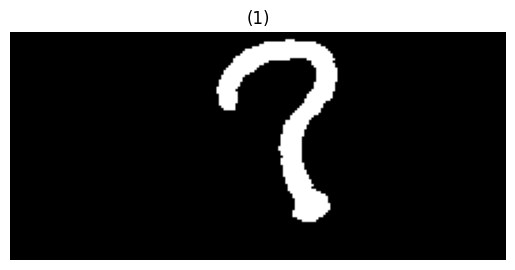

hor : 0 , ver: 0
Predict: question
['1180172', ['6', 5, '']]


In [15]:

def toDigit(digit_image , isHand=False , write=False):
    target_img_size = (32,32)
    if digit_image.shape[1] > digit_image.shape[0]:
        digit_image = cv2.resize(digit_image , [digit_image.shape[1] , digit_image.shape[1]])
        
    # leave a "digit_padding" px in evey dimension
    scale = (target_img_size[1] - digit_padding * 2) / digit_image.shape[0]

    # digit_image = cv2.bitwise_not(digit_image)
    # digit_image = cv2.threshold(digit_image, 50, 255, cv2.THRESH_TOZERO)

    # print(scale)
    digit_image = cv2.resize(digit_image, None, fx=scale, fy=scale)
    # showHist(digit_image)
    # show_images([digit_image])
    # print(digit_image.shape)

    img = np.zeros(target_img_size)
    xO = digit_image.shape[1] / digit_image.shape[0]  # wid / hei
    xO = (1 - xO) / 2
    xO = round(target_img_size[0] * xO)
    img[digit_padding:target_img_size[0] - digit_padding, xO:digit_image.shape[1] + xO] = digit_image
    
    if write:
        writePath = os.path.join("temp" , str(uuid.uuid4()) + ".png")
        print(f"Writing to : {writePath}")
        cv2.imwrite(writePath, img)
        
    img = img.astype(np.uint8)
    
    

    # # print(digit_image.shape)
    # # print(xO)
    #
    # img[digit_padding:target_img_size[0] - digit_padding, xO:digit_image.shape[1] + xO] = digit_image
    # img = img.astype(np.uint8)

    # cv2.imwrite(f"outputs/{str(uuid.uuid4())}.jpg", img)
    # cv2.imwrite(f"outputs/{int(time.time() * 1000000)}-d.jpg", digit_image)

    # io.imshow(img)
    # io.show()

    if not svm_loaded:
        return 'X'

    features = extract_hog_features(img)
    if isHand:
        predict = hand_digits_classifier.predict([features])[0]
    else:
        predict = digits_classifier.predict([features])[0]
    # print(predict)
    return f'{predict}'


def split_code_image(code_image, peak_offset=0.4) -> []:
    # code_image = cv2.Laplacian(code_image, 5)
    # print("sharpen")
    # hist = cv2.calcHist([code_image], [0], None, [256], [0, 256])
    # peak = 0
    # for i in range(len(hist)):
    #     if hist[i] >= hist[peak]:
    #         peak = i
    # showHist(code_image)

    if (OCR_ENABLED):
        value = pytesseract.image_to_string(code_image , config='digits')
        val = value.split('\n')[0]
        print(f"Value: {val}")
        return val

    code_image = gamma_correction(code_image, 0.2)
    # showHist(code_image)
    _, thresholdImage = cv2.threshold(code_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresholdImage = cv2.GaussianBlur(thresholdImage, (3, 3), 0)
    thresholdImage = cv2.erode(thresholdImage, np.ones([2,2]))

    show_images([thresholdImage , code_image] , ["thresholded image" , "input image"])
    # thresholdImage = cv2.erode(thresholdImage, np.ones([2,2]))

    ver = find_vertical_lines(thresholdImage, value=0, forward=1, thickness=1)
    hor = find_horizontal_lines(thresholdImage, value=0, forward=3, thickness=1)

    if len(hor) != 2:   # this is not a student code
        return [], []


    codes = []
    codes_seg = []

    i = 0
    while i < len(ver) // 2:
        codes.append(code_image[hor[0]:hor[1], ver[i * 2]:ver[i * 2 + 1]])
        codes_seg.append(thresholdImage[hor[0]:hor[1], ver[i * 2]:ver[i * 2 + 1]])
        i += 1

    if len(codes) != 7:
        # print("Failed to extract code from the image ..")
        # before failing. try to fix this miss
        avg = 0
        for k in codes:
            avg += k.shape[1]
        avg /= 7   # not averaging by the len because it should be 7

        filtered_cd = []
        filtered_csd = []

        for i, k in enumerate(codes):
            if k.shape[1] > avg * 0.4:  # only add digits that's more than the 20% of the average value
                filtered_cd.append(k)   # others are probably some random pixels
                filtered_csd.append(codes_seg[i])
            else:
                print("Skipped a very small digit")

        codes = filtered_cd
        codes_seg = filtered_csd
        filtered_cd = []
        filtered_csd = []

        for i, k in enumerate(codes):
            k_csd = codes_seg[i]
            v = k.shape[1] / avg
            if v > 1.5:                  # we probably got two digits (or more) in the same image
                print("Attempting to split a wide digit image")
                split = round(v)
                for j in range(split):
                    filtered_cd .append(k[:, k.shape[1] // split * j: k.shape[1] // split * (j+1)])
                    filtered_csd.append(k_csd[:, k_csd.shape[1] // split * j: k_csd.shape[1] // split * (j + 1)])
                    # show_images([k, k_csd])

            else:
                filtered_cd.append(k)
                filtered_csd.append(k_csd)

        codes = filtered_cd
        codes_seg = filtered_csd
        filtered_cd = []
        filtered_csd = []

        if len(codes) != 7:   # ok I give up
            print("failed to read digits")
            show_images([code_image, thresholdImage])
            return [], []

    return codes, codes_seg


def detectHorizontalLines(img):
    kernel = np.ones([3, min(img.shape) // 5])
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    # show_images([opened] , ["DHZ"])
    counters , _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(counters) if len(counters) < 6 else 0


def detectVerticalLines(img):
    kernel = np.ones([min(img.shape) // 5,3])
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    # show_images([opened] , ["DHZ"])
    counters , _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(counters) if len(counters) < 6 else 0

def detectCorrectMark(img):
    debug = np.copy(img)
    if min(img.shape) < 80:
        factor = 80 / min(img.shape)
        nSize = (int(factor * img.shape[0]) , int(factor * img.shape[1]))
        img = cv2.resize(img , nSize)
    
    lines = cv2.HoughLinesP(cv2.ximgproc.thinning(img), 1, np.pi/180, threshold=40, minLineLength=40, maxLineGap=10)
    ok1 = 0
    ok2 = 0
    err = 0
    
    if lines is not None:
        for line in lines:
            (x1 , y1 , x2 , y2) = line[0]
            if x1 > x2:
                x1 = x1 + x2
                x2 = x1 - x2
                x1 = x1 - x2
                y1 = y1 + y2
                y2 = y1 - y2
                y1 = y1 - y2
            
            # print(f'[{x1} , {y1}] -> [{x2} , {y2}]')
            debug = cv2.line(debug , [x1 , y1] , [x2 , y2] , [0])
            angle = math.atan2(y1 - y2 , x2 - x1) * 180 / np.pi
            # print(angle)
            
            if 90 >= angle >= 50:
                ok1 += 1
            elif 45 >= angle >= 10:
                ok2 += 1
            else:
                err += 1
    # print(f'ok1 = {ok1} , ok2 = {ok2} , err = {err}')
    
    # show_images([debug])
    
    return 1 if ok2 == 1 and err == 0 else 0


def calculate_mark(answer , isNum = False):
    min_num = np.min(answer)
    if min_num > 50:
        return 0 # empty image
    else:
        _, thresholdImage = cv2.threshold(answer, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
    show_images([thresholdImage])
    eroded = cv2.erode(thresholdImage , kernel=np.ones([2,2]))
    ver = find_vertical_lines(eroded, value=0, forward=3, thickness=3)
    hor = find_horizontal_lines(eroded, value=0, forward=3, thickness=3)
    
    if len(hor) == 0:
        hor.append(0)
        hor.append(thresholdImage.shape[0] - 1)
        
    if len(ver) == 0:
        ver.append(0)
        ver.append(thresholdImage.shape[1] - 1)
        
    if isNum:
        # crop the image to the digit
        # show_images([thresholdImage[hor[0]:hor[1], ver[0]:ver[1]]] , ["digit"])
        if (OCR_ENABLED):
            
            value = pytesseract.image_to_string(np.array(thresholdImage).astype(np.uint8) , config='digits')
            val = value.split('\n')[0]
            print(f"Value: {val}")
            return val
        else:
            print(thresholdImage[hor[0]:hor[1], ver[0]:ver[1]].shape)
            return toDigit(thresholdImage[hor[0]:hor[1], ver[0]:ver[1]] , write=True)
            
    for i in range(len(ver) // 2):
        if abs(ver[i * 2 + 1] - ver[i * 2]) > max(answer.shape[0] , answer.shape[1]) // 7:
            ver = []
            break
    
    for i in range(len(hor) // 2):
        if abs(hor[i * 2 + 1] - hor[i * 2]) > max(answer.shape[0] , answer.shape[1]) // 7:
            hor = []
            break
    
    ver = len(ver) // 2
    hor = len(hor) // 2
    print(f'hor : {hor} , ver: {ver}')
    
    if hor > 0 and ver == 0:               # horizontal line
        return 5 - hor
    elif ver > 0 and hor == 0:               # vertical line
        return ver
    else:                                    # question mark or a correct sign or a squar
        predict = symbols_classifier.predict([extract_hog_features(thresholdImage , target_img_size=(100,40))])[0]
        print(f"Predict: {predict}")
        if predict == "question":
            return ''
        elif predict == 'correct':
            return 5
        else:
            return 0 # box

def resolve_student(gray_image, code_location, answers_locations) -> []:
    # blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)  # remove noise
    code_image = gray_image[code_location[1]:code_location[3], code_location[0]:code_location[2]]
    # apply a threshold to convert to binary image

    code_digits, code_seg_digit = split_code_image(code_image)
    code = ''
    if len(code_digits) != 7:
        print("Skipping bad digits ..")
        code = 'xxxxxxx'
    else:
        for k in code_seg_digit:
            code += toDigit(k)
        
    mark = []
    isNum = True
    for k in answers_locations:
        answer = gray_image[k[1]:k[3], k[0]:k[2]]
        mark.append(calculate_mark(answer , isNum=isNum))
        isNum = False
        
    print([code , mark])
    return [code , mark]

students = []
for i in range(len(codes_positions)):
    students.append(resolve_student(table, codes_positions[i], questions_positions[i]))
        

This part writes the result into Excel file

In [16]:
# last step, write results
columns = ["Code" , "Q1" , "Q2" , "Q3"]
codes = []
q1    = []
q2    = []
q3    = []
for student in students:
    codes.append(student[0])
    q1.append(student[1][0])
    q2.append(student[1][1])
    q3.append(student[1][2])
    
data = pd.DataFrame({
    "Code" : codes,
    "Q1": q1,
    "Q2": q2,
    "Q3": q3
})

def cond(x):
    if x == '':
        return 'background-color: red'
    return None

data.style.apply(cond)
data.style.map(cond)

writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')
data.to_excel(writer, sheet_name='Sheet1')

workbook  = writer.book
worksheet = writer.sheets['Sheet1']
format1 = workbook.add_format({'bg_color': '#FFC7CE',
                               'font_color': '#9C0006'})




(max_row, max_col) = data.shape
worksheet.conditional_format(1, 1, max_row, max_col,
                             {'type': 'formula',
                              'criteria': '=B2=""',
                              'format': format1
                              }
                             )

writer.close()
print("Created excel file")

Created excel file
